# Clustering

In this notebook we do the three types of clustering discussed 

In [1]:
import math
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from networkx.algorithms.bipartite.cluster import clustering
from opt_einsum.paths import optimal

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
import clustering
import gower

In [2]:
DATASET_DIR = "dataset" + os.sep

In [3]:
merged_df = pd.read_csv(DATASET_DIR + "merge_clean_v2.csv", parse_dates=["date"])
cyclist_df = pd.read_csv(DATASET_DIR + "cyclist_clean_v2.csv")
stages_df = pd.read_csv(DATASET_DIR + "stages_clean_v2.csv", parse_dates=["date"])

In [4]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589771 entries, 0 to 589770
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   _url               589771 non-null  object        
 1   points             589771 non-null  int64         
 2   length             589771 non-null  float64       
 3   profile            475349 non-null  float64       
 4   startlist_quality  589771 non-null  int64         
 5   date               589771 non-null  datetime64[ns]
 6   position           589771 non-null  int64         
 7   cyclist            589771 non-null  object        
 8   cyclist_age        589658 non-null  float64       
 9   delta              589771 non-null  int64         
 10  race               589771 non-null  object        
 11  year               589771 non-null  int64         
 12  stage              589771 non-null  object        
 13  birth_year         589724 non-null  float64 

In [5]:
cyclist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6095 entries, 0 to 6094
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   _url         6095 non-null   object 
 1   name         6095 non-null   object 
 2   birth_year   6084 non-null   float64
 3   height       3134 non-null   float64
 4   nationality  6095 non-null   object 
 5   BMI          3134 non-null   float64
 6   continent    6095 non-null   object 
dtypes: float64(3), object(4)
memory usage: 333.4+ KB


In [6]:
stages_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5281 entries, 0 to 5280
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   _url               5281 non-null   object        
 1   stage              5281 non-null   object        
 2   race               5281 non-null   object        
 3   date               5281 non-null   datetime64[ns]
 4   points             5281 non-null   int64         
 5   length             5281 non-null   int64         
 6   profile            3326 non-null   float64       
 7   startlist_quality  5281 non-null   int64         
 8   year               5281 non-null   int64         
 9   season             5281 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 412.7+ KB


In [4]:
merged_df = merged_df.dropna()
cyclist_df = cyclist_df.dropna()
stages_df = stages_df.dropna()

In [5]:
cyclist_df.drop(columns=["_url", "name", "nationality"], inplace=True)
stages_df.drop(columns=["_url", "stage", "date", "race"], inplace=True)
merged_df.drop(
    columns=["_url", "date", "cyclist", "race", "stage", "nationality"], inplace=True
)

In [11]:
# transformation
transformed_cyclists_data, preprocessor_cyclists = clustering.transform(
    cyclist_df,
    categorical_cols=["continent"],
    standardize_cols=["height", "BMI"],
    minmax_cols=["birth_year"],
)

transformed_stages_data, preprocessor_stages = clustering.transform(
    stages_df,
    categorical_cols=["profile", "season"],
    minmax_cols=["year", "points", "length", "startlist_quality"],
)

## TODO: put scaling of merged df here. The problem is that the values that are present in the other tables should be scaled in the same way as the other tables.
## Meaning that you cannot straightforward scale the merged df (frequency matters!!).

## TODO: When computing distances, DO NOT USE EUCLIDEAN on categorical data. Use a different distance metric. I have put gower in DBScan, but not in KMeans.

ValueError: A given column is not a column of the dataframe

In [12]:
merged_df.info()
cyclist_df.info()
stages_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 402686 entries, 0 to 589770
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   points             402686 non-null  int64  
 1   length             402686 non-null  float64
 2   profile            402686 non-null  float64
 3   startlist_quality  402686 non-null  int64  
 4   position           402686 non-null  int64  
 5   cyclist_age        402686 non-null  float64
 6   delta              402686 non-null  int64  
 7   year               402686 non-null  int64  
 8   birth_year         402686 non-null  float64
 9   weight             402686 non-null  float64
 10  height             402686 non-null  float64
 11  season             402686 non-null  object 
dtypes: float64(6), int64(5), object(1)
memory usage: 39.9+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 3134 entries, 1 to 6094
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---

Let's define transform and inverse function for our dataset. 
Some algorithm cannot work on entire datasets so let's define also a samples parameter to sample a subset of rows.

## K-means

So first of all we are going to fine tune K. using the coso method with sse plot

In [13]:
def kmeans_explore(
    df, cat_cols, stand_cols, minmax_cols, comps=0, max_k=40, random_state=1804
):
    transformed_data = clustering.transform(df, cat_cols, stand_cols, minmax_cols)[0]
    # Reduce dims if requested. Try with T-SNE???
    if comps != 0:
        pca = PCA(n_components=comps)
        transformed_data = pca.fit_transform(transformed_data)

    # Compute SSE for different cluster sizes
    sse = []
    k_values = range(1, max_k + 1)

    
    for k in k_values:
        kmeans = KMeans(
            n_clusters=k, init="k-means++", n_init=5, random_state=random_state
        )
        kmeans.fit(transformed_data)
        sse.append(kmeans.inertia_)

    # Plot SSE
    plt.figure(figsize=(8, 5))
    plt.plot(k_values, sse, marker="o")
    plt.title("Elbow Method for Optimal k")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Sum of Squared Errors (SSE)")
    plt.grid(True)
    plt.show()


def optimal_kmeans(df, cat_cols, stand_cols, minmax_cols, n_clusters, fname):
    df = df.copy()
    transformed_data, preproc = clustering.transform(df, cat_cols, stand_cols, minmax_cols)
    
    # Explore more after we find the best K
    kmeans = KMeans(
        n_clusters=n_clusters, init="k-means++", n_init=50, random_state=1804
    )
    kmeans.fit(transformed_data)

    df["Cluster"] = kmeans.labels_
    df["Distance_to_Centroid"] = kmeans.transform(transformed_data).min(axis=1)

    # Inverse transform centroids for interpretability
    centroids_df = clustering.inverse_transformation(
        kmeans.cluster_centers_, preproc, cat_cols, stand_cols, minmax_cols
    )
    centroids_df["Cluster"] = centroids_df.index

    df.to_csv(f"{fname}-kmeans-result.csv", index=False)
    centroids_df.to_csv(f"{fname}-kmeans_centroids.csv", index=False)

    return df, centroids_df, kmeans

Small tables can be analyzed easily since they don't require much memory. We can make deep analysis

In [14]:
kmeans_explore(cyclist_df, ["continent"], ["height", "BMI"], ["birth_year"])
kmeans_explore(stages_df,["profile", "season"], ["year", "points", "length", "startlist_quality"], [])

ValueError: A given column is not a column of the dataframe

Big table require too much time without dim reduction. So we can explore less or we need to reduce dimensionality. 

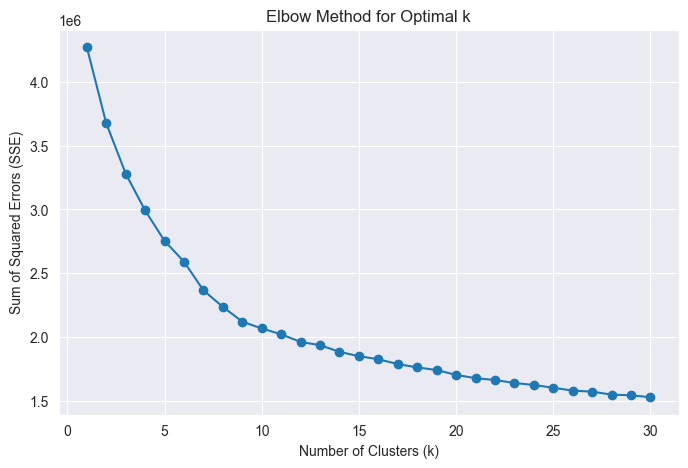

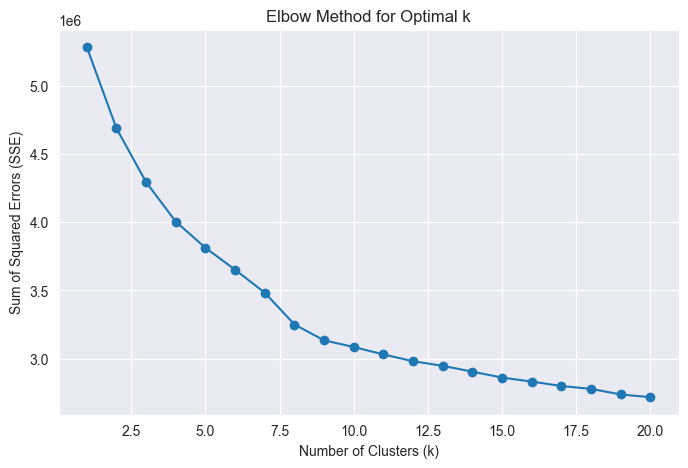

In [ ]:
# With PCA
kmeans_explore(
    races_df,
    ["stage", "race", "profile", "season", "nationality", "cyclist"],
    [
        "startlist_quality",
        "year",
        "points",
        "length",
        "birth_year",
        "position",
        "cyclist_age",
        "delta",
    ],
    comps=20,
    max_k=30,
)

# No reduction
kmeans_explore(
    races_df,
    ["stage", "race", "profile", "season", "nationality", "cyclist"],
    [
        "startlist_quality",
        "year",
        "points",
        "length",
        "birth_year",
        "position",
        "cyclist_age",
        "delta",
    ],
    comps=0,
    max_k=20,
)

Also we can observe that with or without dim reduction we have same behaviour.

We can now get the results of the best hyppa paramitar looking where the graph bends, then we can do a more fine grained exploration with the best K

In [ ]:
optimal_kmeans(cyclist_df, ["continent"], ["height", "BMI"], ["birth_year"], 7, "dataset/cyclists")
optimal_kmeans(stages_df,["profile", "season"], ["year", "points", "length", "startlist_quality"], [], 8, 'dataset/stages')

# To fix
optimal_kmeans(
    races_df,
    ["stage", "race", "profile", "season", "nationality", "cyclist"],
    [
        "startlist_quality",
        "year",
        "points",
        "length",
        "birth_year",
        "position",
        "cyclist_age",
        "delta",
    ],
    8,
    "merged",
)

(        points    length  profile  startlist_quality  position  \
 0          100  162000.0      1.0               1241         0   
 2          100  162000.0      1.0               1241         2   
 4          100  162000.0      1.0               1241         4   
 9          100  162000.0      1.0               1241         9   
 10         100  162000.0      1.0               1241        10   
 ...        ...       ...      ...                ...       ...   
 589766      80    8400.0      1.0                878       192   
 589767      80    8400.0      1.0                878       193   
 589768      80    8400.0      1.0                878       194   
 589769      80    8400.0      1.0                878       195   
 589770      80    8400.0      1.0                878       196   
 
                    cyclist  cyclist_age  delta            race  year    stage  \
 0               sean-kelly         22.0      0  tour-de-france  1978  stage-6   
 2           rene-bittinger   

## Hierarchical 
As suggested by notebook we are going to use scipy library to make hc using a subset of rows to reduce memory and time required for big merged table

In [9]:
from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram


def hc(df, cat_cols, stand_cols, minmax_cols, color_threshold=10, truncate_mode="lastp", p=12, samples=0):
    # Linkage and distance metrics to test
    transformed_data = clustering.transform(df, cat_cols, stand_cols, minmax_cols, samples=samples)[0]

    linkage_methods = ["single", "complete", "average", "ward", "centroid", "median"]
    distance_metrics = ["euclidean"]

    # Initialize the plot grid
    fig, axes = plt.subplots(
        len(linkage_methods), len(distance_metrics), figsize=(20, 20)
    )
    fig.tight_layout(pad=4.0)

    for i, method in enumerate(linkage_methods):
        for j, metric in enumerate(distance_metrics):
            try:
                # Compute pairwise distances and hierarchical linkage
                data_dist = pdist(transformed_data, metric=metric)
                data_link = linkage(data_dist, method=method)

                # Plot dendrogram
                dendrogram(
                    data_link,
                    ax=axes[i, j],
                    color_threshold=color_threshold,
                    truncate_mode=truncate_mode,
                    p=p,
                    no_labels=False,
                )
                axes[i, j].set_title(f"{method.capitalize()} - {metric.capitalize()}")
            except Exception as e:
                axes[i, j].set_title(
                    f"{method.capitalize()} - {metric.capitalize()} (Failed)"
                )
                print(f"Error with {method}-{metric}: {e}")

    plt.show()

let's run the algorithm on all table with all methods and metrics

In [10]:
hc(cyclist_df, ["continent"], ["height", "BMI"], ["birth_year"])
hc(stages_df,["profile", "season"], ["year", "points", "length", "startlist_quality"], [])

ValueError: A given column is not a column of the dataframe

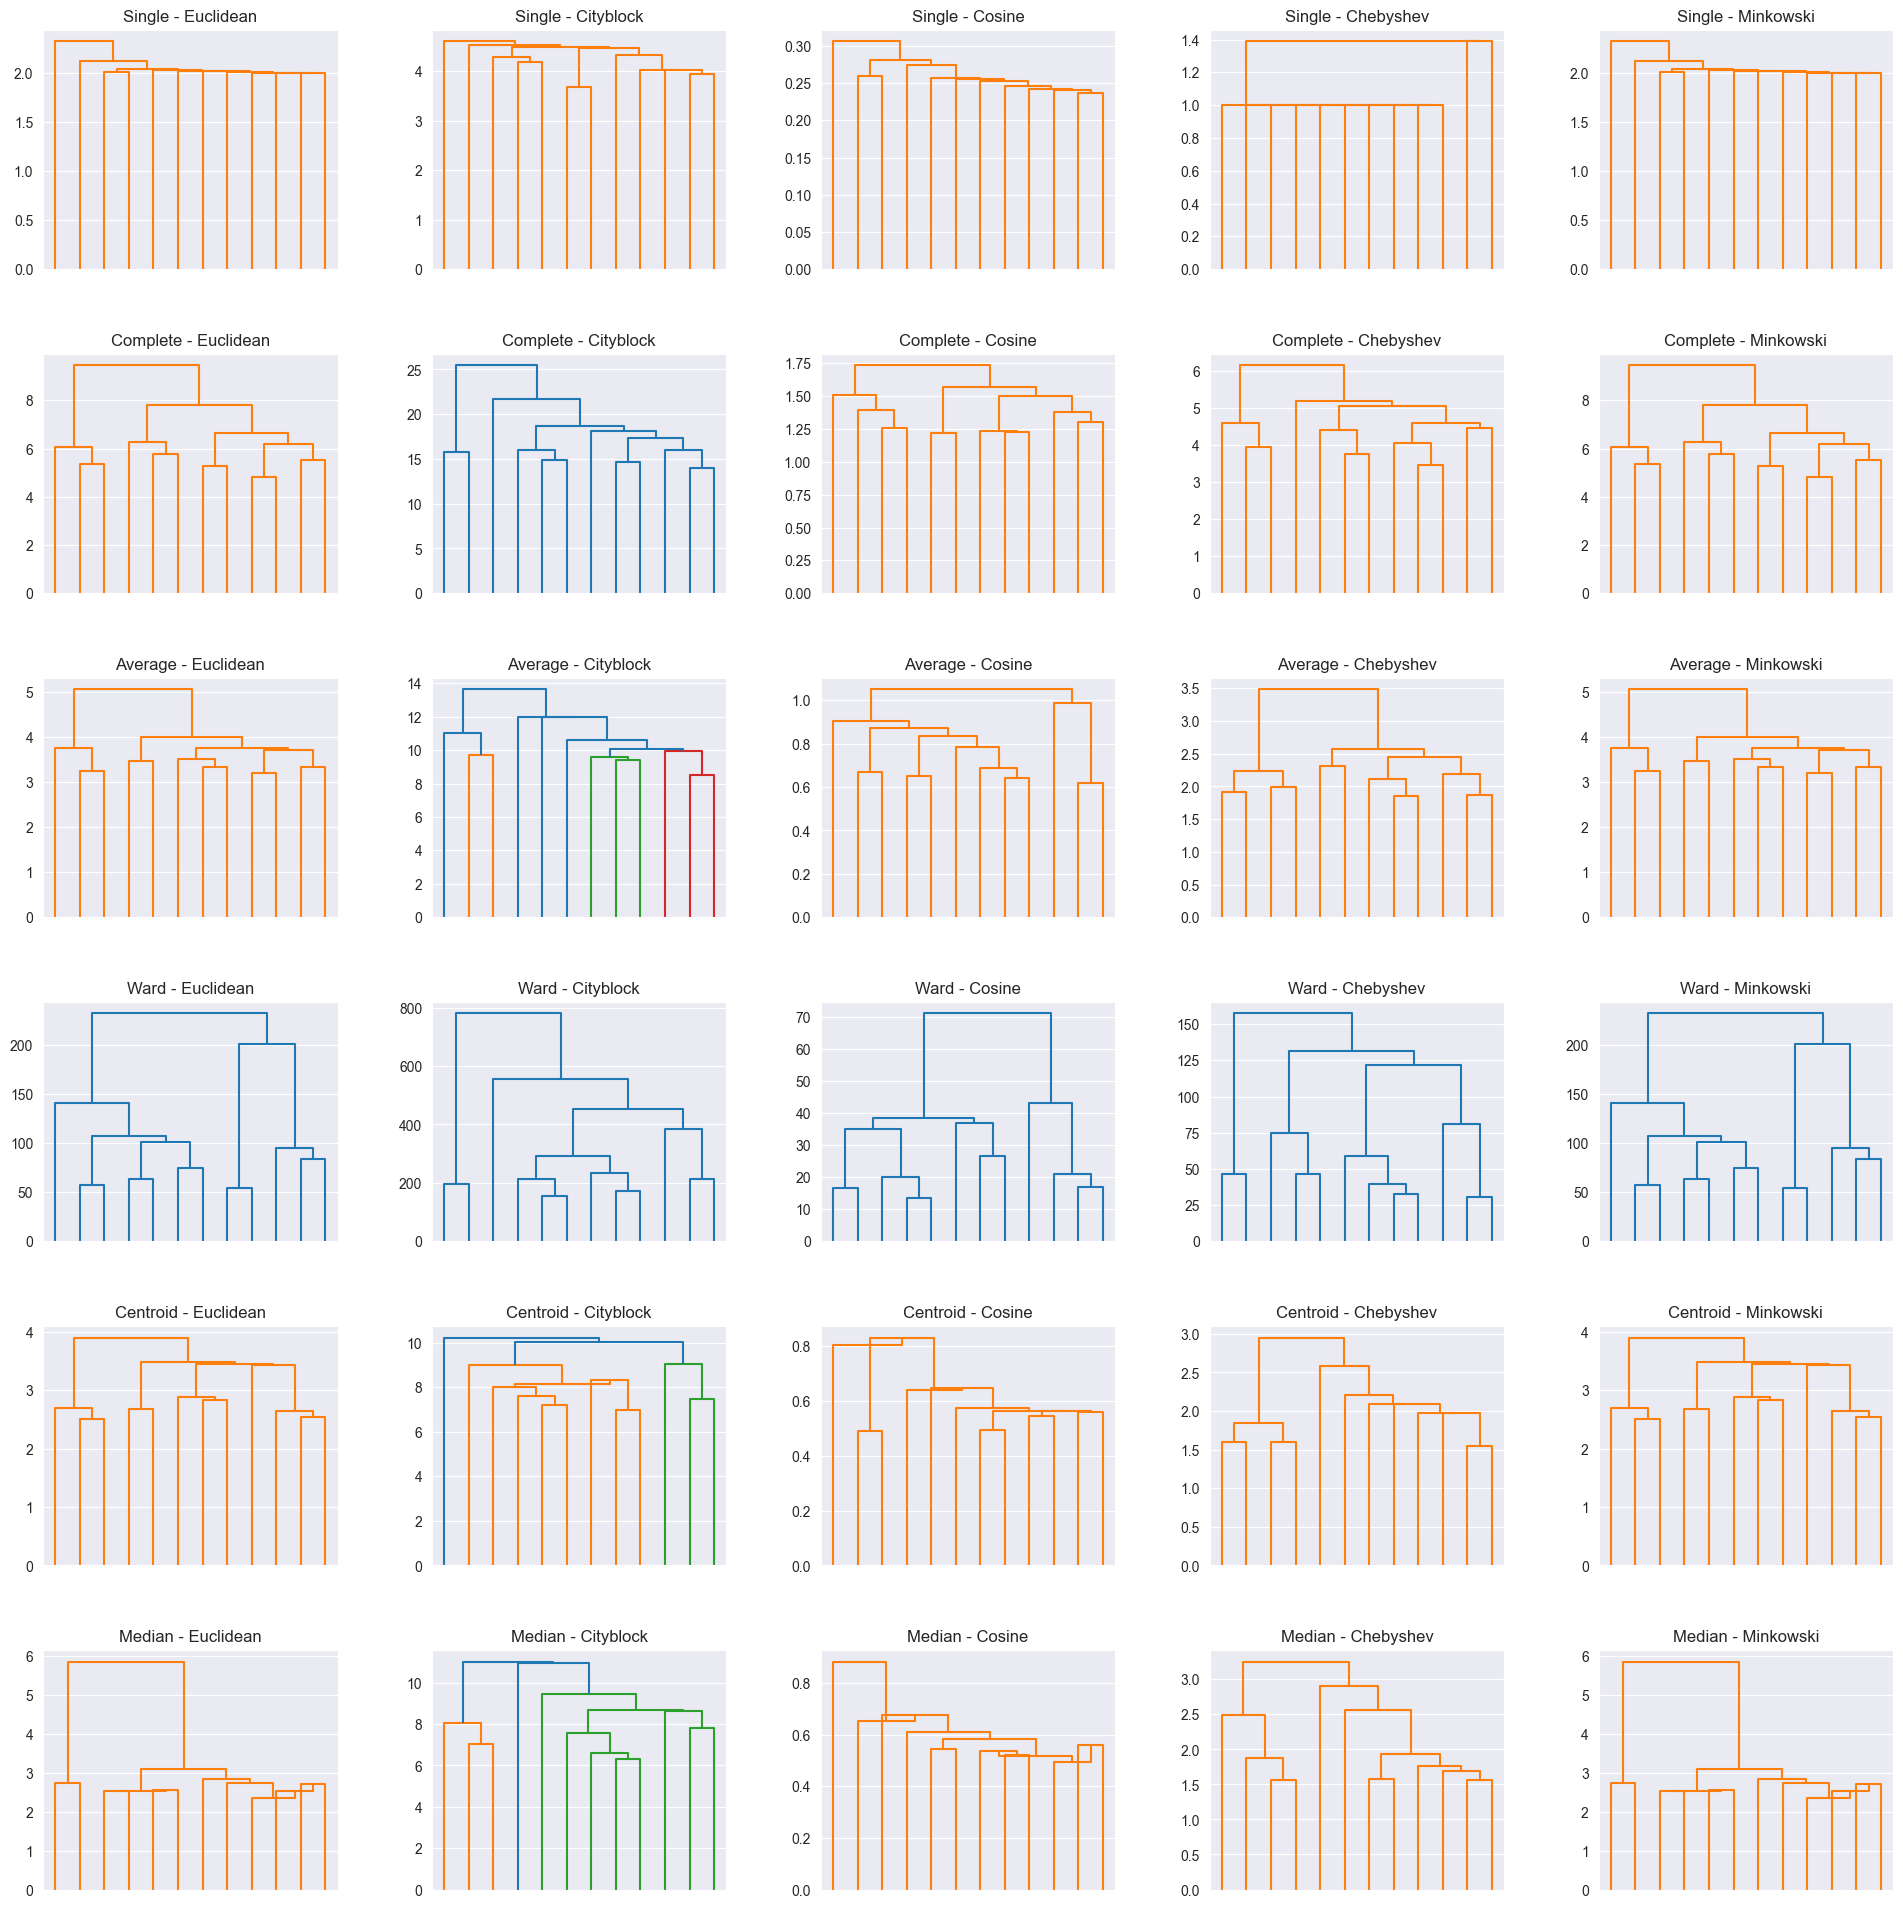

In [ ]:
hc(
    merged_df,
    ["stage", "race", "profile", "season"],
    ["startlist_quality", "year", "points", "length"],
    samples=20000,
)

## DBscan
Let's define our min_sample parameter as dimentions * 2

In [ ]:
# TODO add the merged df here and compute gower distance

# Cannot standardize directly, mean and variance change because of repetitions
# also non normally distributed data cannot be standardized, must use minmax scaling

dist1 = gower.gower_matrix(transformed_cyclists_data)
k1 = transformed_cyclists_data.shape[1] * 2
print(dist1.shape)


dist2 = gower.gower_matrix(transformed_stages_data)
k2 = transformed_stages_data.shape[1] * 2
print(dist2.shape)

dists = [dist1, dist2]
ks = [k1, k2]

(3134, 3134)
(3326, 3326)


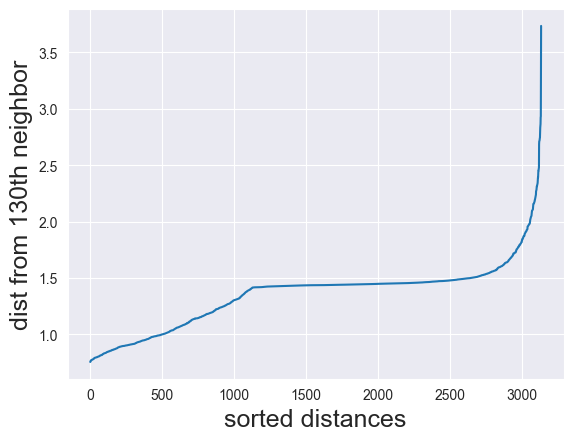

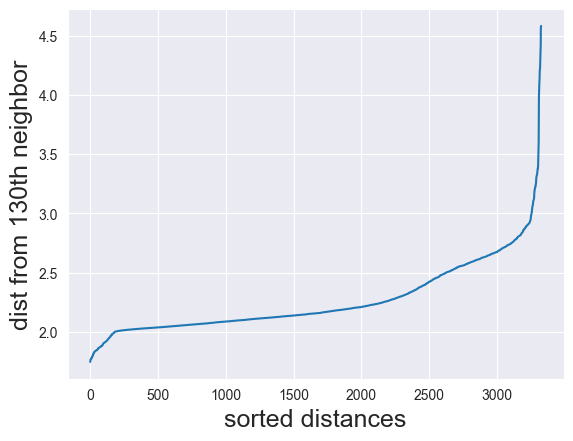

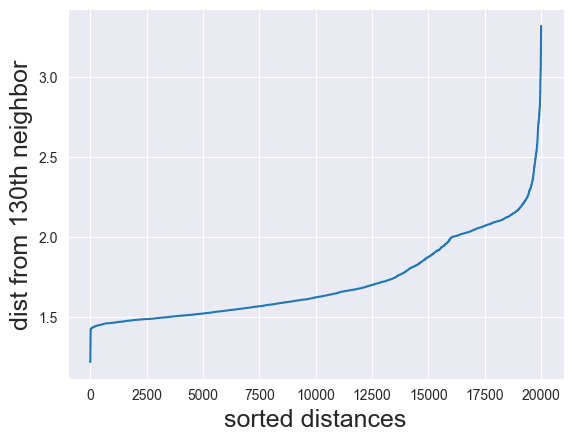

In [ ]:
import numpy as np
import math

for dist, k in zip(dists, ks):
    kth_distances = list()
    for d in dist:
        index_kth_distance = np.argsort(d)[k]
        kth_distances.append(d[index_kth_distance])

    plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
    plt.ylabel("dist from %sth neighbor" % k, fontsize=18)
    plt.xlabel("sorted distances", fontsize=18)
    plt.show()

Now we can look for the optimal epsilon and use min_samples as Dimensions * 2 as suggested in the notebook

In [ ]:
from sklearn.cluster import DBSCAN

df = clustering.transform(cyclist_df, ["nationality"], ["birth_year", "BMI"])[0]
dbscan = DBSCAN(
    eps=1.6, min_samples=df.shape[1] * 2
)  # Hyperparameters: eps = look at graph, min_samples = dimentions * 2
labels = dbscan.fit_predict(df)
df["Cluster"] = labels

df = clustering.transform(
        stages_df,
        ["stage", "race", "profile", "season"],
        ["startlist_quality", "year", "points", "length"],
)[0]
dbscan = DBSCAN(
    eps=2.3, min_samples=df.shape[1] * 2
)  # Hyperparameters: eps and min_samples can be adjusted
labels = dbscan.fit_predict(df)
df["Cluster"] = labels

df = clustering.transform(
        merged_df,
        ["stage", "race", "profile", "season"],
        ["startlist_quality", "year", "points", "length"],
)[0]
dbscan = DBSCAN(
    eps=1.6, min_samples=df.shape[1] * 2
)  # Hyperparameters: eps and min_samples can be adjusted
labels = dbscan.fit_predict(df)
df["Cluster"] = labels